# GDAS - correct sensor response

This notebook provides a simple example on how to correct a Stryde trace for the sensor response. 

The dataset used in this notebook was collected with Stryde nodes at KAUST as part of the GDAS project on Dec 7 2023.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pylops
import matplotlib.pyplot as plt

from matplotlib.colors import SymLogNorm
from pylops.signalprocessing import FFT2D

from pystryde.reader import *
from pystryde.preproc import *
from pystryde.cmap import cmaps
from pystryde.visual import *

In [2]:
def interpolate_response(response, t, sub=2):
    """Interpolate sensor response in frequency domain
    
    NOTE: to preserve energy, the max amplitude wil be rescaled by the subsampling factor
    """
    if sub % 2 != 0:
        raise ValueError('sub must be divisible by 2')
    
    nt, dt = t.size, t[1] - t[0]
    F = np.fft.rfftfreq(nt, dt)
    Response = np.fft.rfft(response)

    # Interpolate sensor response to 1ms
    Responsepad = np.pad(Response, (0, (sub-1)*(len(Response) -1))) 
    responsepad = np.fft.irfft(Responsepad)
    dtpad = dt / sub
    tpad = np.arange(responsepad.size) * dtpad
    tpad -= tpad[tpad.size // 2]
       
    print(np.allclose(responsepad[::sub], response))
    
    return responsepad, tpad

## Single shot

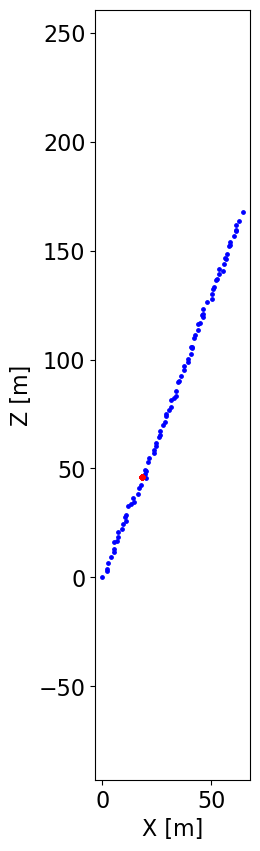

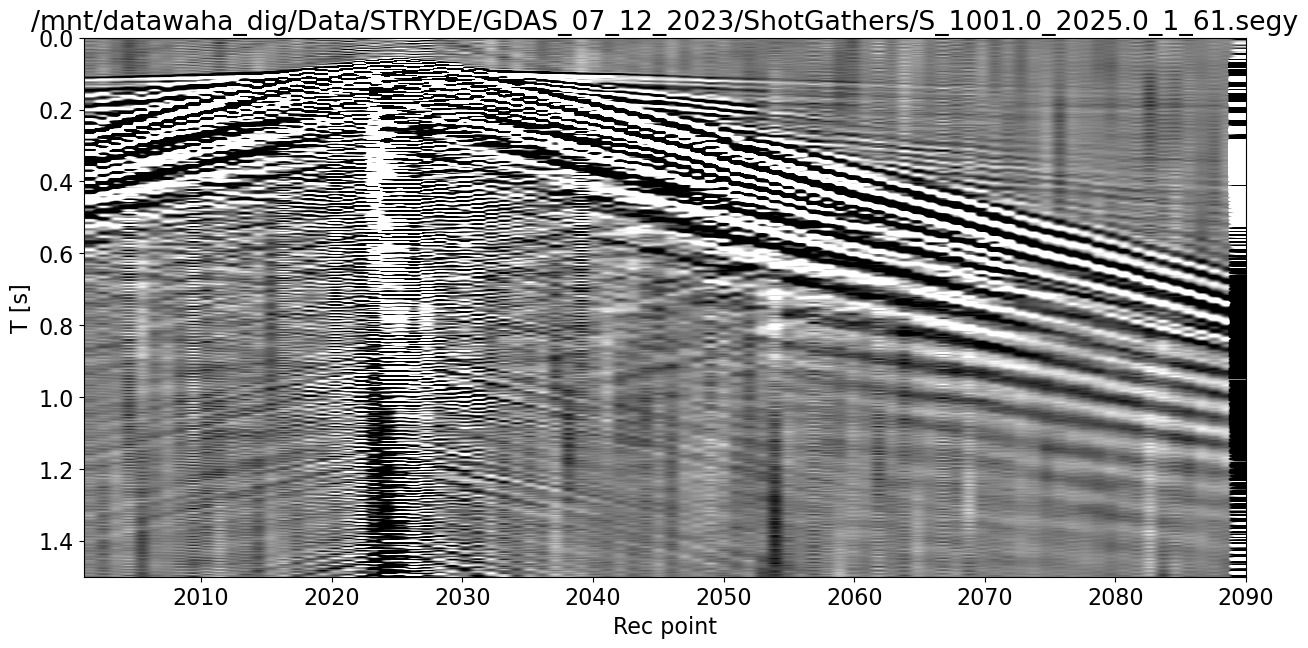

In [3]:
filename = '/mnt/datawaha_dig/Data/STRYDE/GDAS_07_12_2023/ShotGathers/S_1001.0_2025.0_1_61.segy'
f = strydeshot(filename)
f.interpret()
f.getshot()
f.recx = f.recx.astype(np.float32)
f.recy = f.recy.astype(np.float32)
f.recx[f.recx==0] = np.nan
f.recx[np.isnan(f.recx)] = np.nanmean(f.recx)
f.recy[f.recy==0] = np.nan
f.recy[np.isnan(f.recy)] = np.nanmean(f.recy)

fig, ax = f.plotgeom(local=True, figsize=(2, 10))
ax.axis('equal')

f.plotshot(figsize=(15,7), itmax=1500, cmap='gray', clip=1e-3);

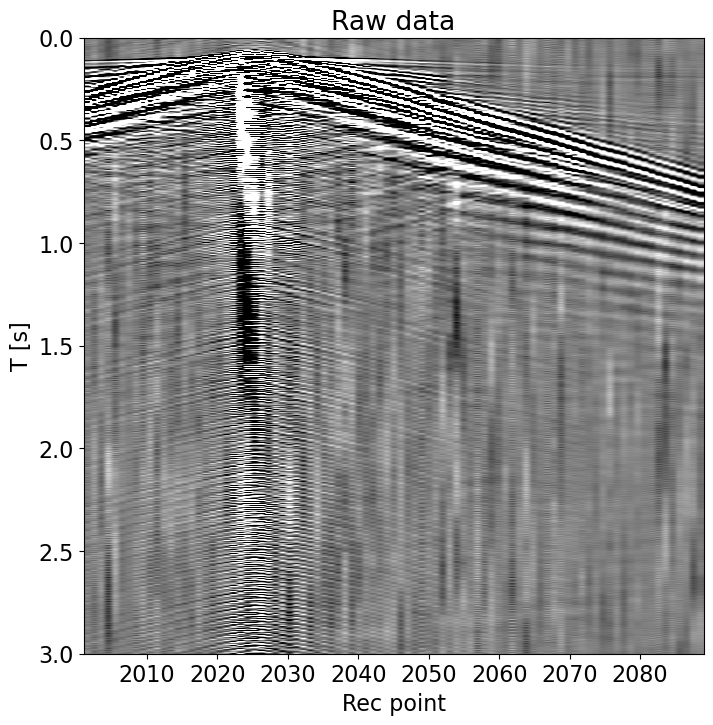

In [4]:
# Extract useful data
data = f.data[:-1]
recpoint = f.recpoint[:-1]
nr = len(recpoint)
tdata = f.t.copy()

plt.figure(figsize=(8, 8))
plt.imshow(data.T, cmap='gray', vmin=-1e-3, vmax=1e-3, 
           extent=(recpoint[0], recpoint[-1], tdata[-1], tdata[0]))
plt.axis('tight')
plt.xlabel('Rec point')
plt.ylabel('T [s]')
plt.title('Raw data')
plt.ylim(3, 0);

## Sensor response

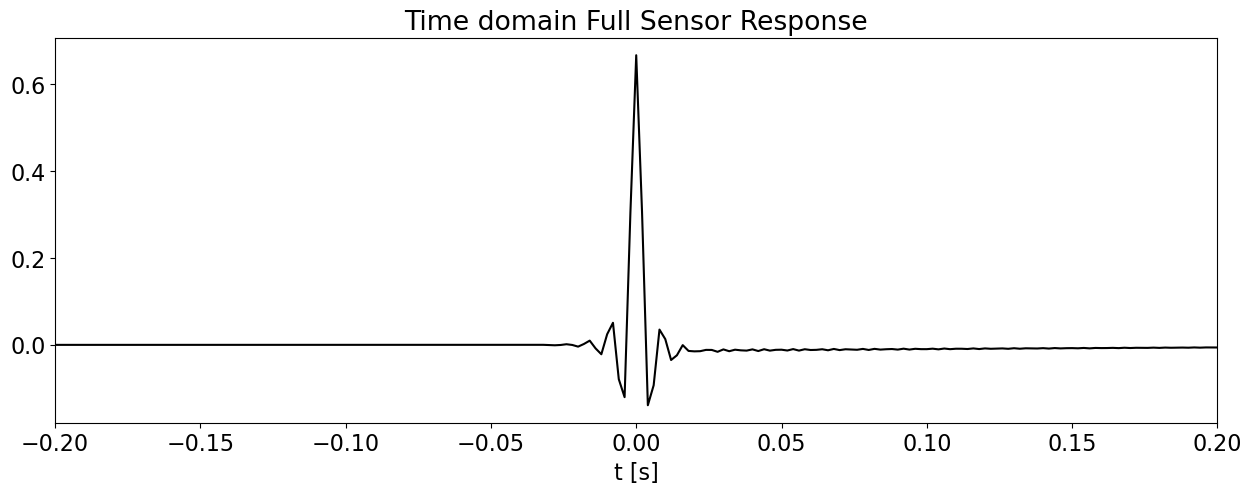

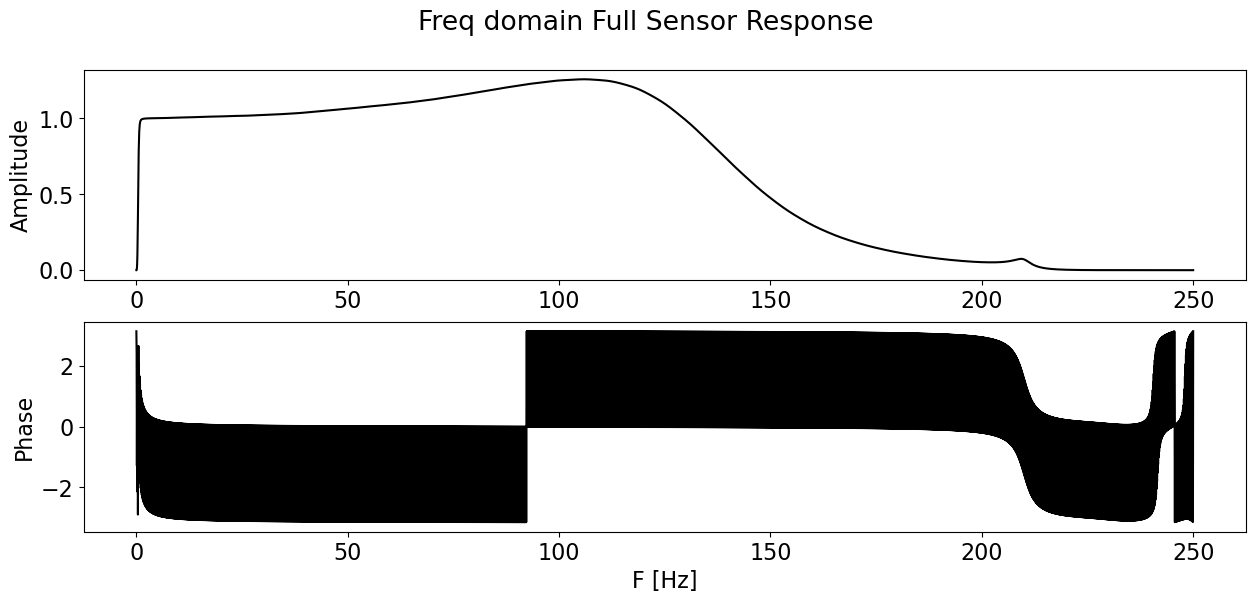

In [5]:
# Load response and display
response = np.loadtxt('/mnt/datawaha_dig/Data/STRYDE/FullSensorResponse_2ms.txt')

t = response[:, 0]
response = response[:, 1]
nt = response.size
dt = 0.002 # 2ms # np.abs(response[1, 0] - response[0, 0])

plt.figure(figsize=(15, 5))
plt.plot(t, response, 'k')
plt.xlim(-0.2, 0.2)
plt.title('Time domain Full Sensor Response')
plt.xlabel('t [s]')

F = np.fft.rfftfreq(nt, dt)
Response = np.fft.rfft(response)

fig, axs = plt.subplots(2, 1, figsize=(15, 6))
fig.suptitle('Freq domain Full Sensor Response')
axs[0].plot(F, np.abs(Response) , 'k')
axs[0].set_ylabel('Amplitude')
axs[1].plot(F, np.angle(Response) , 'k')
axs[1].set_ylabel('Phase')
axs[1].set_xlabel('F [Hz]');

False


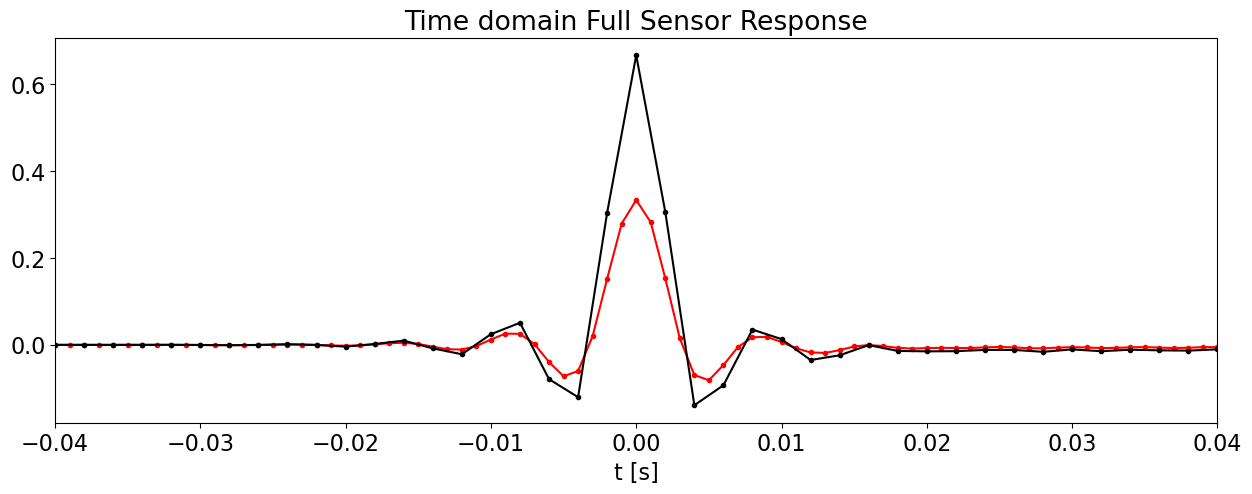

In [6]:
responsepad, tpad = interpolate_response(response, t, sub=2)

plt.figure(figsize=(15, 5))
plt.plot(tpad, responsepad, '.-r')
plt.plot(t, response, '.-k')
plt.xlim(-0.04, 0.04)
plt.title('Time domain Full Sensor Response')
plt.xlabel('t [s]');

response = responsepad.copy()
t = tpad.copy()
dt = t[1] - t[0]

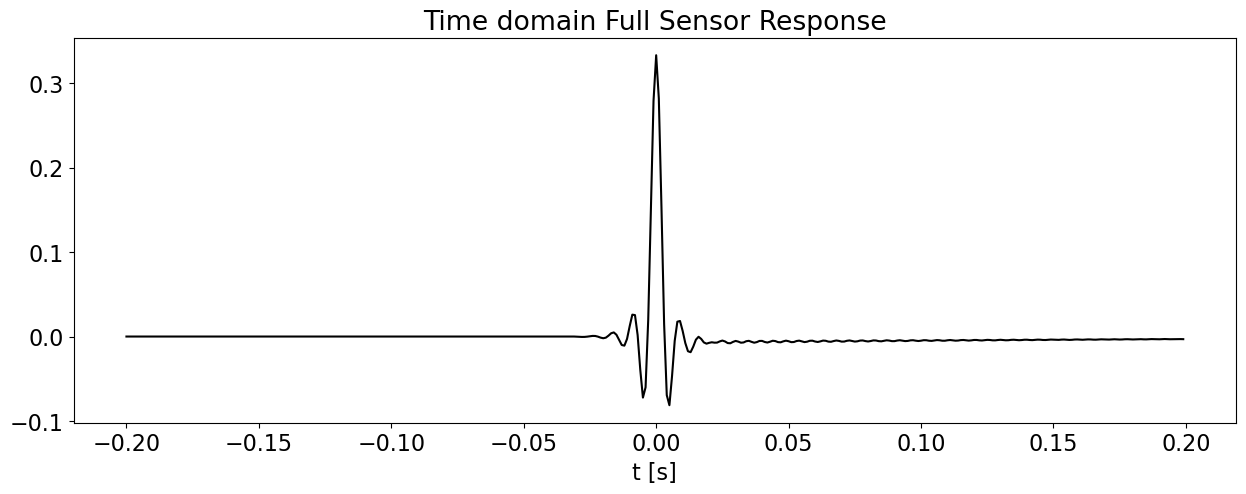

In [7]:
# Make shorter response (cut zeros away on either side)
ntside = 200
t = t[np.argmax(response)-ntside:np.argmax(response)+ntside]
response  = response[np.argmax(response)-ntside:np.argmax(response)+ntside]

plt.figure(figsize=(15, 5))
plt.plot(t, response, 'k')
#plt.xlim(-0.2, 0.2)
plt.title('Time domain Full Sensor Response')
plt.xlabel('t [s]');

## Sensor response correction

To begin with, we consider the case where we want to flatten the response within the entire range of frequencies where some signal is recorded

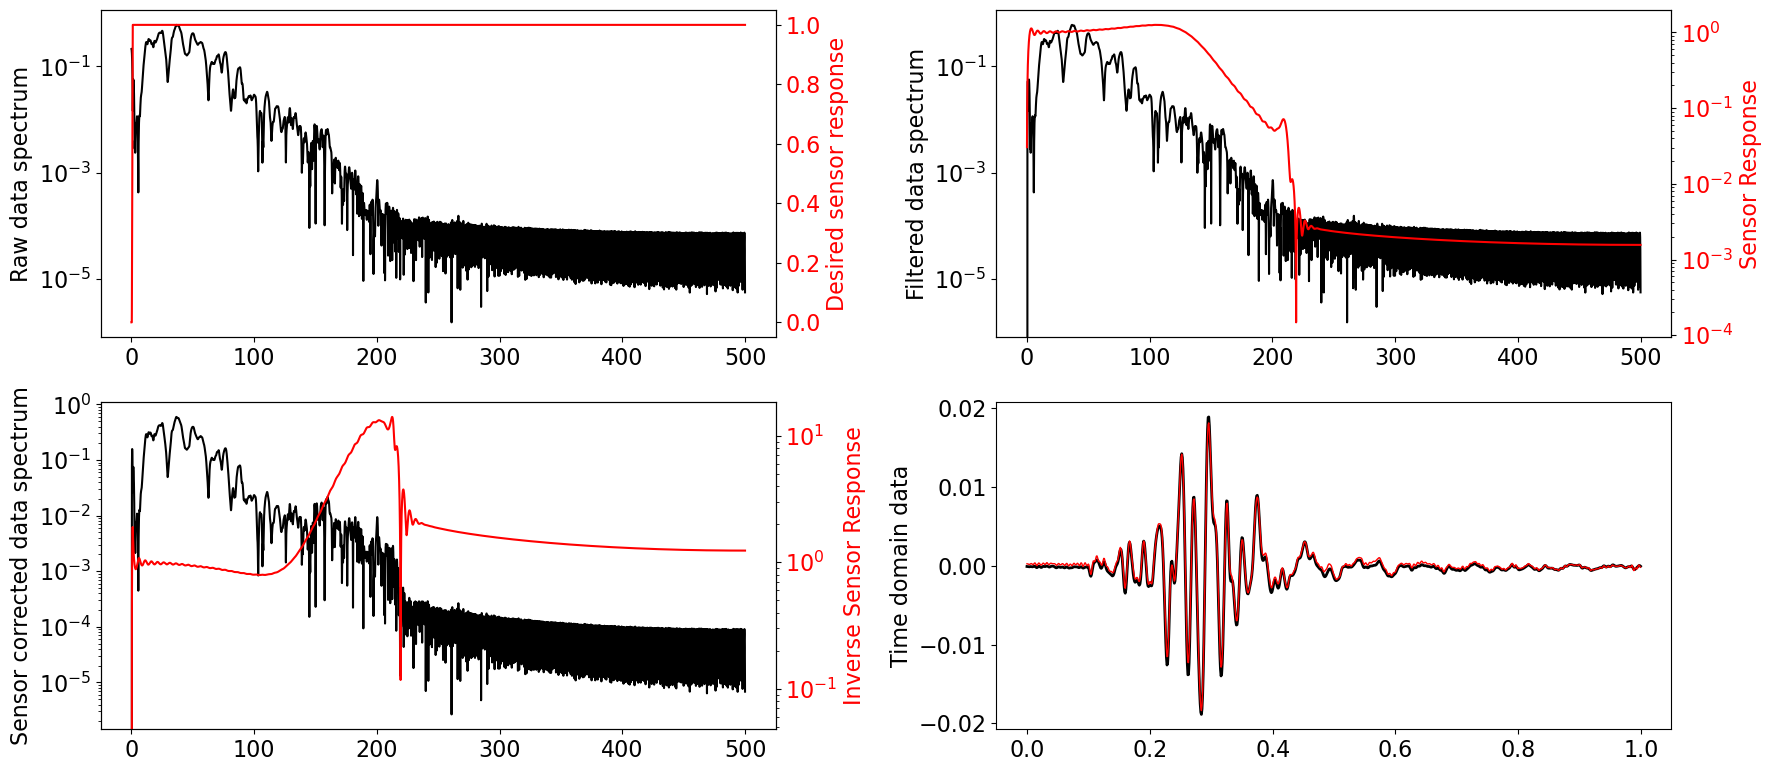

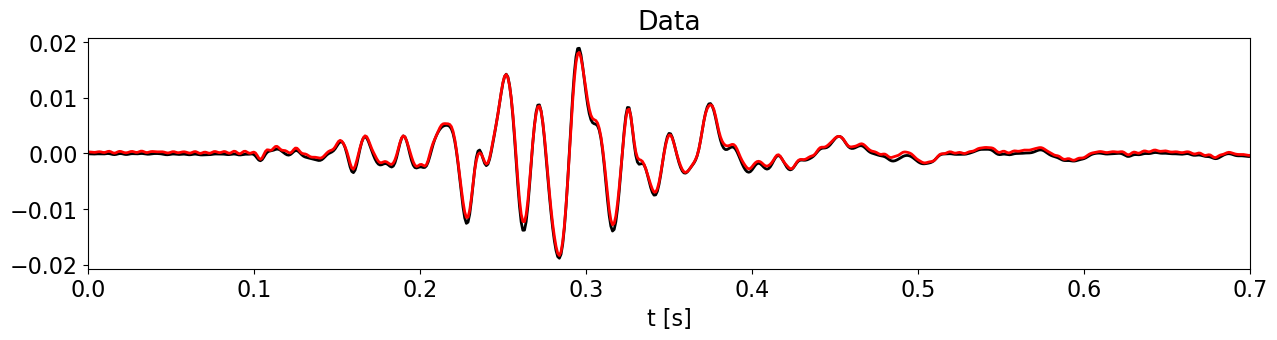

In [8]:
itmax = 1000 # len(f.t)
fcorners = [0.3, 1., None, None]

datafilt, Responseout, fout = correct_sensor_response(data[:, :itmax], response, t, 
                                                      nfft=nt * 4, fcorners=fcorners, nsmooth=2, 
                                                      waterlevel=60, plotflag=True, plottype=plt.semilogy)

plt.figure(figsize=(15, 3))
plt.plot(tdata[:itmax], data[nr//2, :itmax], 'k', lw=2)
plt.plot(tdata[:itmax], datafilt[nr//2], 'r', lw=2)
plt.xlim(0, 0.7)
plt.title('Data')
plt.xlabel('t [s]');

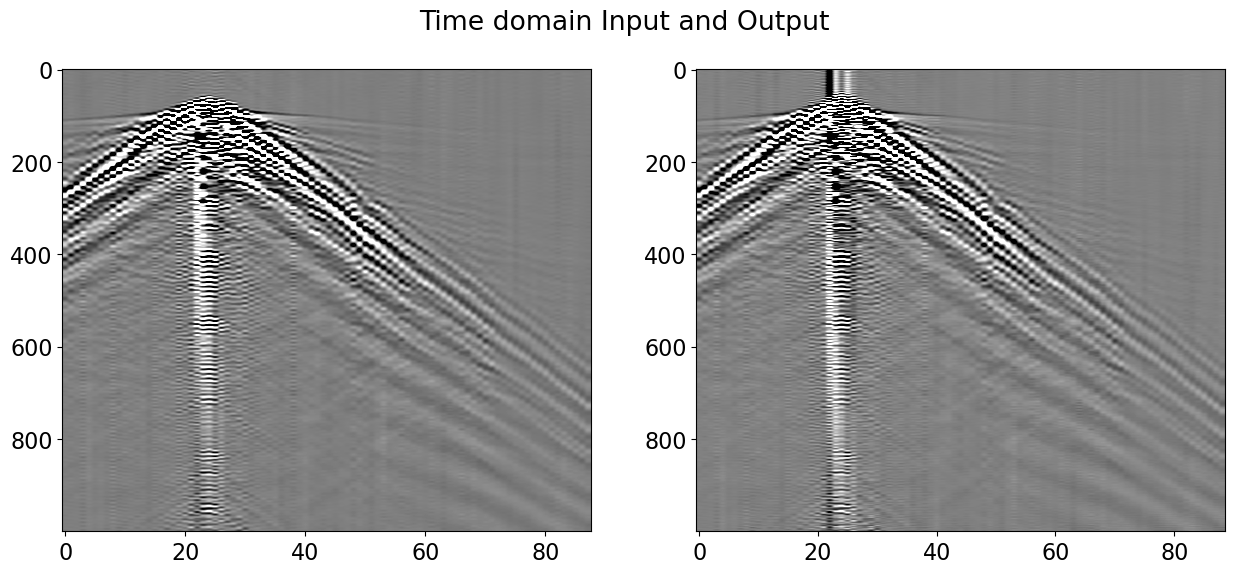

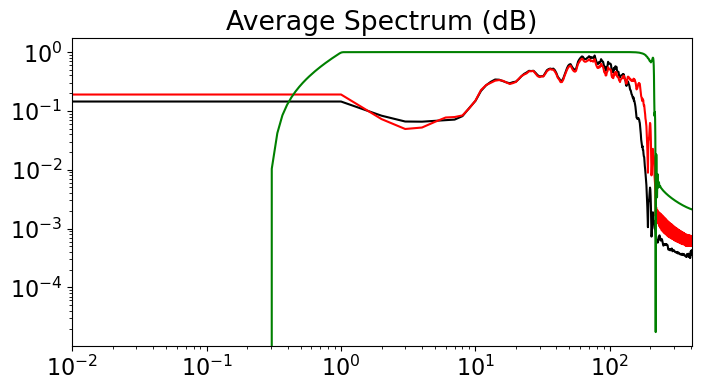

In [9]:
# Display data and average spectrum
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Time domain Input and Output')
axs[0].imshow(data[:-1, :itmax].T, cmap='gray', vmin=-0.01*data.max(), vmax=0.01*data.max())
axs[0].axis('tight')
axs[1].imshow(datafilt.T, cmap='gray', vmin=-0.01*data.max(), vmax=0.01*data.max())
axs[1].axis('tight')
                         
D, freq = averagespectrum(data[:, :itmax].T, dt)
Dfilt, _ = averagespectrum(datafilt.T, dt)

plt.figure(figsize=(8, 4))
plt.loglog(freq, np.abs(D), 'k')
plt.loglog(freq, np.abs(Dfilt), 'r')
plt.loglog(fout, Responseout, 'g')
plt.title('Average Spectrum (dB)')
plt.xlim(1e-2, 410);

Let's now do the same with a narrower band 

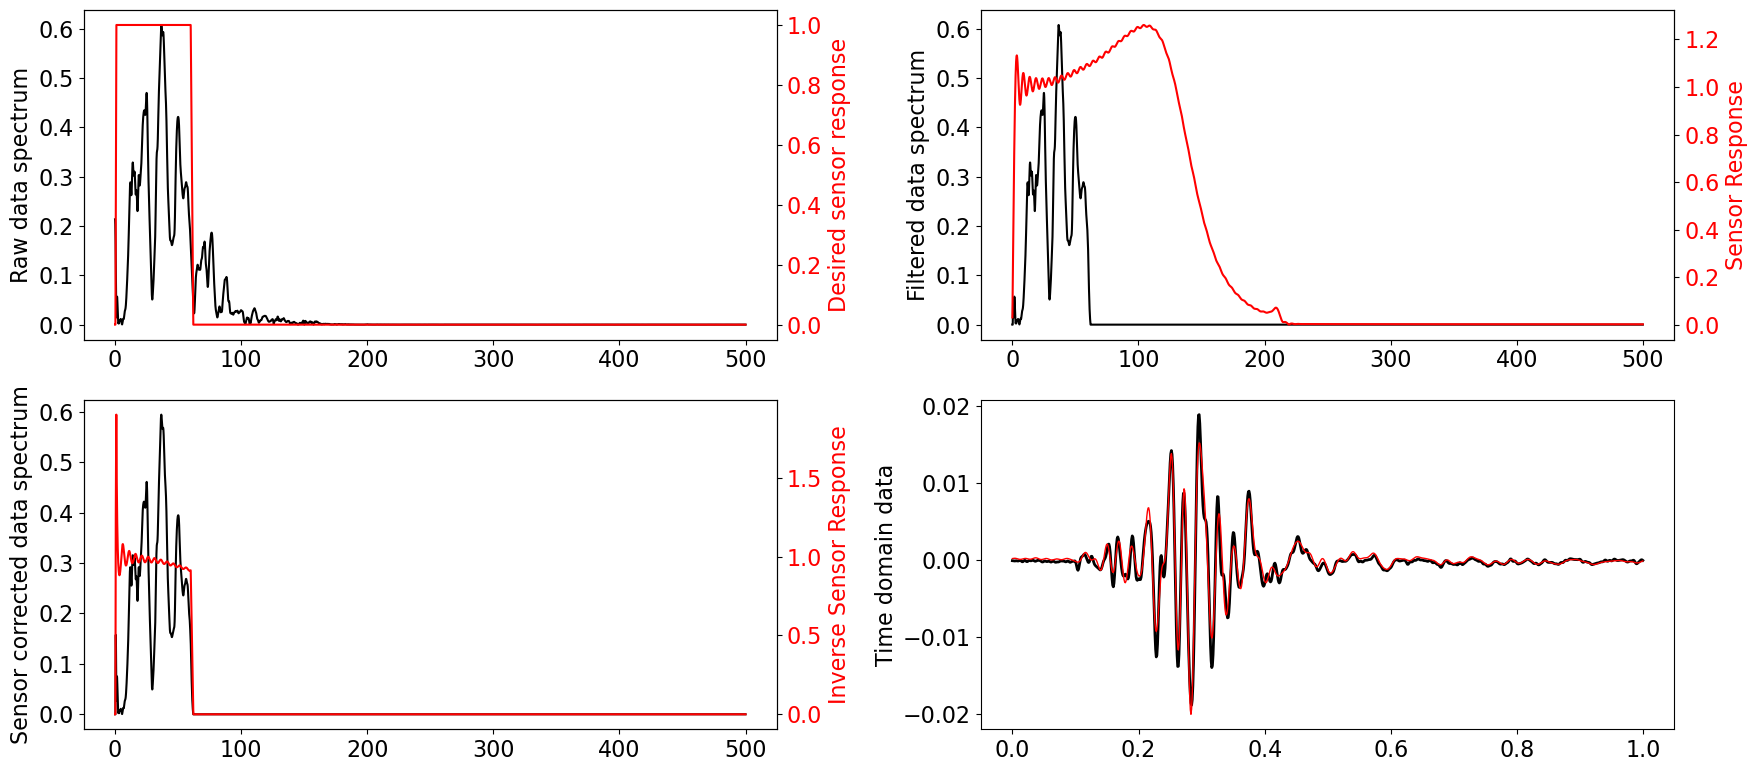

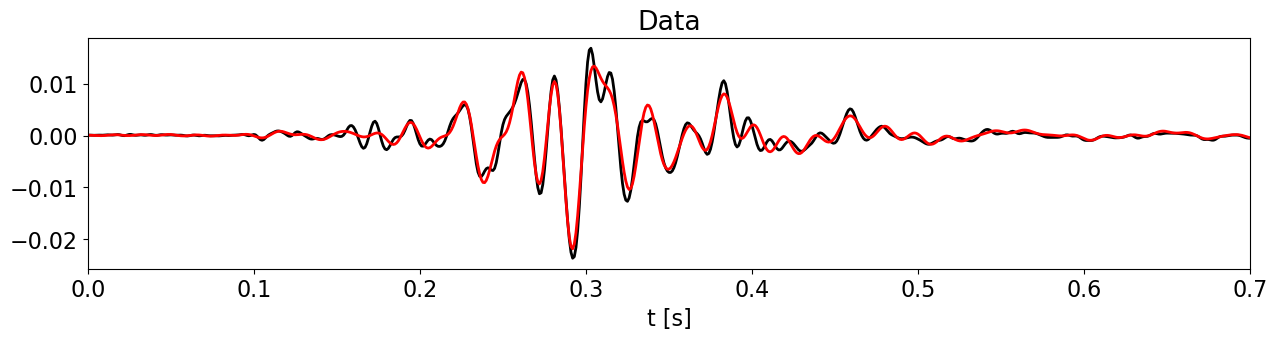

In [10]:
itmax = 1000 # len(f.t)
fcorners = [0.3, 1., 60, 62]
taper = np.zeros_like(F)

datafilt, Responseout, fout = correct_sensor_response(data[:-1, :itmax], response, t, 
                                                      nfft=nt * 4, fcorners=fcorners, nsmooth=2, 
                                                      waterlevel=60, plotflag=True);

plt.figure(figsize=(15, 3))
plt.plot(tdata[:itmax], data[len(f.recidx)//2, :itmax], 'k', lw=2)
plt.plot(tdata[:itmax], datafilt[len(f.recidx)//2], 'r', lw=2)
plt.xlim(0, 0.7)
plt.title('Data')
plt.xlabel('t [s]');

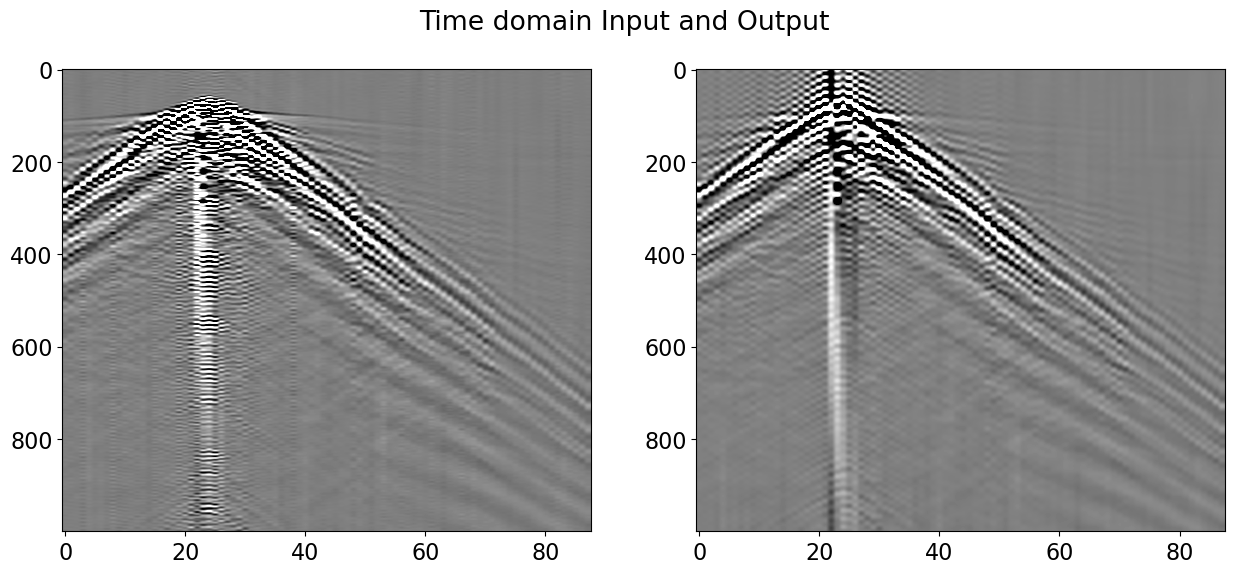

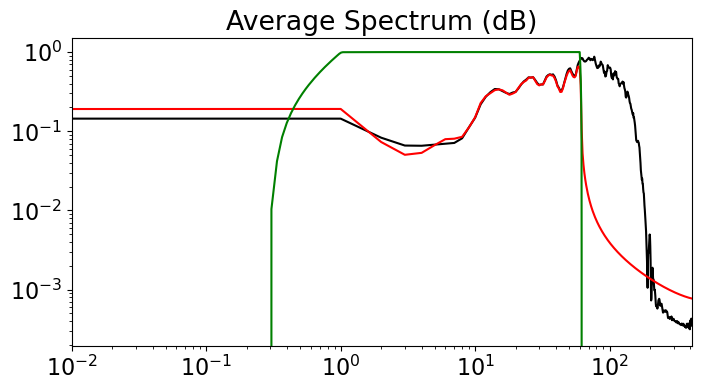

In [11]:
# Display data and average spectrum
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Time domain Input and Output')
axs[0].imshow(data[:-1, :itmax].T, cmap='gray', vmin=-0.01*data.max(), vmax=0.01*data.max())
axs[0].axis('tight')
axs[1].imshow(datafilt.T, cmap='gray', vmin=-0.01*data.max(), vmax=0.01*data.max())
axs[1].axis('tight')

D, freq = averagespectrum(data[:, :itmax].T, dt)
Dfilt, _ = averagespectrum(datafilt.T, dt)

plt.figure(figsize=(8, 4))
plt.loglog(freq, np.abs(D), 'k')
plt.loglog(freq, np.abs(Dfilt), 'r')
plt.loglog(fout, Responseout, 'g')
plt.title('Average Spectrum (dB)')
plt.xlim(1e-2, 410);